## Library

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Data Plot

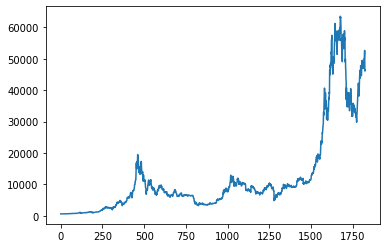

In [33]:
training_set = pd.read_csv('../2022_Problem_C_DATA/BCHAIN-MKPRU.csv')
# training_set = pd.read_csv('../2022_Problem_C_DATA/LBMA-GOLD.csv')

training_set = training_set.iloc[:,1:2].values

plt.plot(training_set)
plt.show()

## Dataloading

In [34]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

ratio = 1
train_size = int(len(y) * ratio)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## Model

In [35]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## Training

In [55]:
criterion = torch.nn.MSELoss()
pred = torch.zeros((train_size, 1))

for day in range(1, train_size):
    trainX = Variable(torch.Tensor(np.array(x[0:day])))
    trainY = Variable(torch.Tensor(np.array(y[0:day])))
    lstm = LSTM(1, 1, 3, 1)
    lstm.train()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=0.01)
    for epoch in range(200):
        outputs = lstm(trainX)
        optimizer.zero_grad()
        
        # obtain the loss function
        loss = criterion(outputs, trainY)
        loss.backward()
        optimizer.step()
    if day % 10 == 0:
        print(day, " loss: %1.5f" % (loss.item()))
    lstm.eval()
    predX = lstm(trainX)
    pred[day] = predX[-1,0]

10  loss: 0.00000
20  loss: 0.00000
30  loss: 0.00000
40  loss: 0.00000
50  loss: 0.00000
60  loss: 0.00000
70  loss: 0.00000
80  loss: 0.00000
90  loss: 0.00000
100  loss: 0.00000
110  loss: 0.00000
120  loss: 0.00000
130  loss: 0.00000
140  loss: 0.00001
150  loss: 0.00001
160  loss: 0.00001
170  loss: 0.00001
180  loss: 0.00000
190  loss: 0.00001
200  loss: 0.00001
210  loss: 0.00001
220  loss: 0.00001
230  loss: 0.00001
240  loss: 0.00002
250  loss: 0.00002
260  loss: 0.00003
270  loss: 0.00006
280  loss: 0.00005
290  loss: 0.00005
300  loss: 0.00002
310  loss: 0.00015
320  loss: 0.00009
330  loss: 0.00000
340  loss: 0.00000
350  loss: 0.00012
360  loss: 0.00023
370  loss: 0.00013
380  loss: 0.00000
390  loss: 0.00024
400  loss: 0.00000
410  loss: 0.00019
420  loss: 0.00016
430  loss: 0.00056
440  loss: 0.00054
450  loss: 0.00060
460  loss: 0.00003
470  loss: 0.00034
480  loss: 0.00017
490  loss: 0.00005
500  loss: 0.00006
510  loss: 0.00044
520  loss: 0.00007
530  loss: 0.00010
54

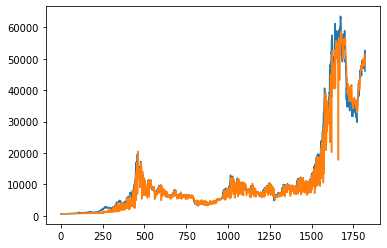

In [61]:
dataY_plot = dataY.data.numpy()
data_predict = pred.detach().numpy()
data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)
plt.plot(dataY_plot)
plt.plot(data_predict)
np.savez('BITCOIN_LSTM.npz', Pred=data_predict, GT = dataY_plot)

In [38]:
num_epochs = 1000
learning_rate = 0.01

input_size = 1
hidden_size = 3
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.04811
Epoch: 100, loss: 0.00051
Epoch: 200, loss: 0.00030
Epoch: 300, loss: 0.00025
Epoch: 400, loss: 0.00024
Epoch: 500, loss: 0.00023
Epoch: 600, loss: 0.00022
Epoch: 700, loss: 0.00021
Epoch: 800, loss: 0.00020
Epoch: 900, loss: 0.00021


## Testing

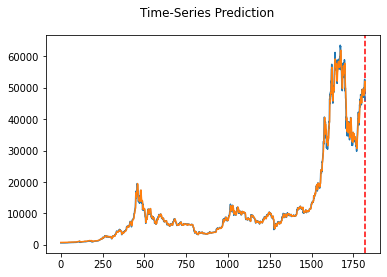

In [39]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()